In [8]:
from google.colab import drive
# from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

In [23]:
# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels


In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for CNN input (Ensure correct shape for VGG19)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [25]:
# Load VGG19 model pre-trained on ImageNet (exclude the top layers)
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [26]:

# Freeze the layers of VGG19 base model
for layer in vgg_base.layers:
    layer.trainable = False

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten # Import Flatten here

# Build the model using Sequential
model = Sequential([
    vgg_base,
    Flatten(),  # Flatten instead of GlobalAveragePooling2D for VGG19
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout to avoid overfitting
    Dense(1, activation='sigmoid')  # Binary classification output layer
])


In [27]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Define Data Generator for Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit the data generator to the training data
datagen.fit(X_train)


In [29]:
# Define Learning Rate Reduction and Early Stopping for better convergence
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions on validation data
        y_pred = (self.model.predict(self.validation_data[0]) > 0.5).astype("int32")
        y_true = self.validation_data[1]

        # Print classification report metrics: precision, recall, f1-score
        report = classification_report(y_true, y_pred, output_dict=True)
        print(f"Epoch {epoch + 1} Classification Report:")
        print(f"Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}, F1-Score: {report['1']['f1-score']:.4f}")

# Create an instance of the MetricsCallback and set validation data for it
metrics_callback = MetricsCallback()
metrics_callback.validation_data = (X_test, y_test)

In [31]:
# Train the model
batch_size = 128
epochs = 3  # Adjust epochs for desired training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[lr_reduction, early_stopping, metrics_callback]
)


Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step
Epoch 1 Classification Report:
Precision: 0.7358, Recall: 0.8521, F1-Score: 0.7897
63/63 ━━━━━━━━━━━━━━━━━━━━ 816s 13s/step - accuracy: 0.7525 - loss: 0.4767 - val_accuracy: 0.7763 - val_loss: 0.4422 - learning_rate: 0.0010
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step
Epoch 2 Classification Report:
Precision: 0.7703, Recall: 0.7781, F1-Score: 0.7742
63/63 ━━━━━━━━━━━━━━━━━━━━ 855s 13s/step - accuracy: 0.7765 - loss: 0.4592 - val_accuracy: 0.7763 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step
Epoch 3 Classification Report:
Precision: 0.7289, Recall: 0.9017, F1-Score: 0.8062
63/63 ━━━━━━━━━━━━━━━━━━━━ 788s 13s/step - accuracy: 0.7860 - loss: 0.4360 - val_accuracy: 0.7863 - val_loss: 0.4239 - learning_rate: 0.0010


In [32]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.7689 - loss: 0.4390
Test Accuracy: 78.63%


In [33]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 2, 2, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,598,789 (82.39 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 1,049,604 (4.00 MB)

In [34]:
model.save("FINAL_VGG 19_model.h5")
model.save('FINAL_VGG 19_model.keras')

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

# Predictions
# y_train_pred = model.predict(X_train)
# y_train_pred_classes = np.argmax(y_train_pred, axis=1)
# y_train_true_classes = np.argmax(y_train, axis=1)

# y_test_pred = model.predict(X_test)
# y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# y_test_true_classes = np.argmax(y_test, axis=1)

y_train_pred = model.predict(X_train)
y_train_pred_classes = (y_train_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_train_true_classes = np.argmax(y_train, axis=1) # This line is removed
y_train_true_classes = y_train # y_train already contains the true class labels

y_test_pred = model.predict(X_test)
y_test_pred_classes = (y_test_pred > 0.5).astype(int) # Convert probabilities to class labels (0 or 1)
#y_test_true_classes = np.argmax(y_test, axis=1) # This line is removed
y_test_true_classes = y_test # y_test already contains the true class labels

# Metrics
train_precision = precision_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_recall = recall_score(y_train_true_classes, y_train_pred_classes, average='weighted', zero_division=0)
train_f1 = f1_score(y_train_true_classes, y_train_pred_classes, average='weighted')
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)

test_precision = precision_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_recall = recall_score(y_test_true_classes, y_test_pred_classes, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

251/251 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step
Training Metrics:
Accuracy: 0.7959, Precision: 0.8141, Recall: 0.7959, F1-Score: 0.7932

Testing Metrics:
Accuracy: 0.7863, Precision: 0.8035, Recall: 0.7863, F1-Score: 0.7837


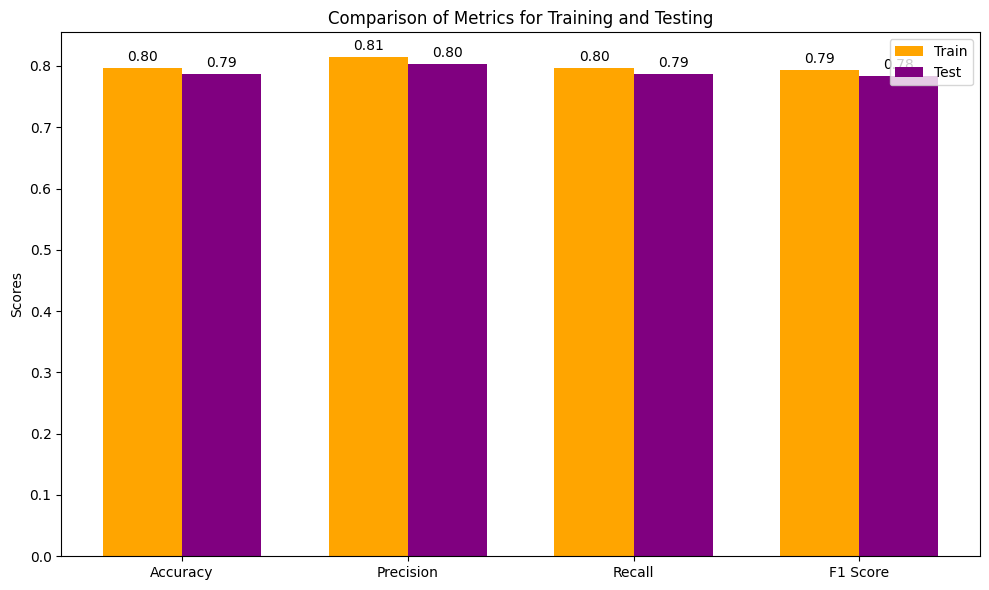

In [36]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_values = [train_accuracy, train_precision, train_recall, train_f1]
test_values = [test_accuracy, test_precision, test_recall, test_f1]

# Set up the bar plot
width = 0.35  # Width of the bars
x = np.arange(len(metrics))  # The label locations

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for training and testing metrics
rects1 = ax.bar(x - width/2, train_values, width, label='Train', color='orange')
rects2 = ax.bar(x + width/2, test_values, width, label='Test', color='purple')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for Training and Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to add the labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels for each bar
add_labels(rects1)
add_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()

In [37]:
!pip install xgboost scikit-learn

In [38]:
!pip install SVC scikit-learn

  Preparing metadata (setup.py) ... done
  Created wheel for SVC: filename=SVC-0.1-py3-none-any.whl size=1868 sha256=777b0b8afb000b648fe111b69c92e69372b75d658629d23bc8ab8413e362cc7d
  Stored in directory: /root/.cache/pip/wheels/88/51/46/316b33cfa9e39d0749762daa17b6a8646e3050079185747370
Successfully built SVC


**VGG+SUPPORT VECTOR CLASSIFIER**

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import seaborn as sns

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Rescale and reshape the features (for VGG19 input)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)  # Reshaping to match VGG19 input

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Load pre-trained VGG19 model (exclude top layers)
input_shape = (64, 64, 3)
base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_vgg19.layers:
    layer.trainable = False

# Extract features using VGG19
vgg19_model = Model(inputs=base_vgg19.input, outputs=GlobalAveragePooling2D()(base_vgg19.output))
X_train_features = vgg19_model.predict(X_train)
X_test_features = vgg19_model.predict(X_test)

# Train an SVC classifier
svc_classifier = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svc_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = svc_classifier.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))




251/251 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step
Test Accuracy: 79.13%

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.72      0.78      1016
           1       0.75      0.86      0.80       987

    accuracy                           0.79      2003
   macro avg       0.80      0.79      0.79      2003
weighted avg       0.80      0.79      0.79      2003




Confusion Matrix:

[[733 283]
 [135 852]]


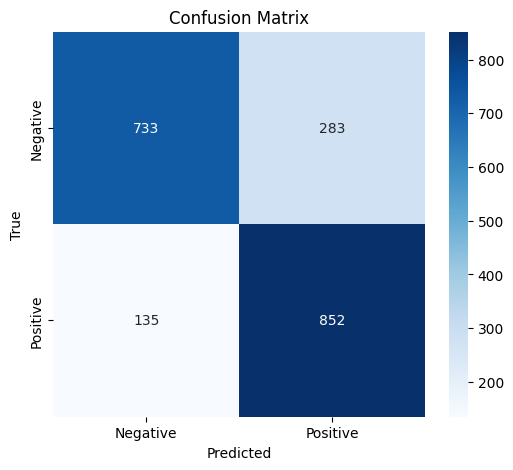

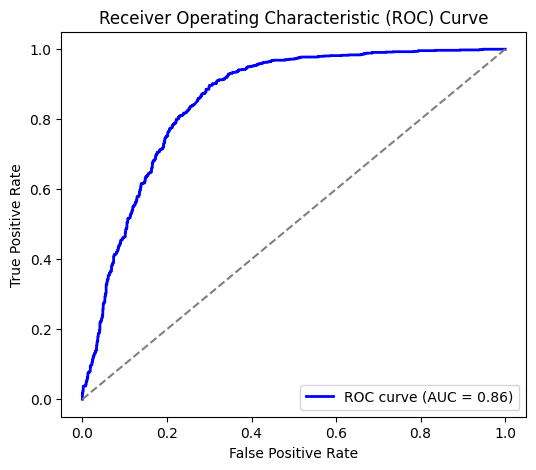

In [4]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n")
print(conf_matrix)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
y_prob = svc_classifier.predict_proba(X_test_features)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**VGG+RANDOM FOREST**

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import seaborn as sns

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Rescale and reshape the features (for VGG19 input)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)  # Reshaping to match VGG19 input

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Load pre-trained VGG19 model (exclude top layers)
input_shape = (64, 64, 3)
base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_vgg19.layers:
    layer.trainable = False

# Extract features using VGG19
vgg19_model = Model(inputs=base_vgg19.input, outputs=GlobalAveragePooling2D()(base_vgg19.output))
X_train_features = vgg19_model.predict(X_train)
X_test_features = vgg19_model.predict(X_test)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


251/251 ━━━━━━━━━━━━━━━━━━━━ 521s 2s/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step
Test Accuracy: 83.18%

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1016
           1       0.79      0.89      0.84       987

    accuracy                           0.83      2003
   macro avg       0.84      0.83      0.83      2003
weighted avg       0.84      0.83      0.83      2003




Confusion Matrix:

[[783 233]
 [104 883]]


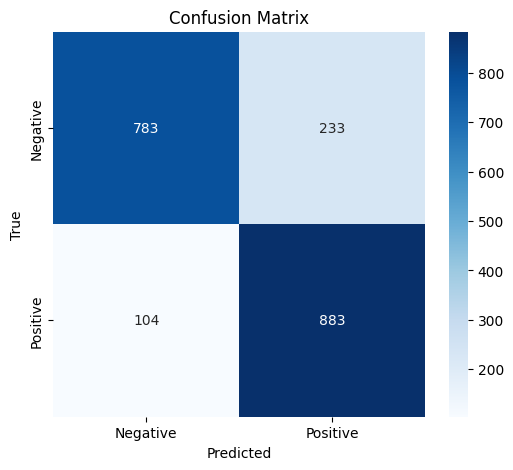

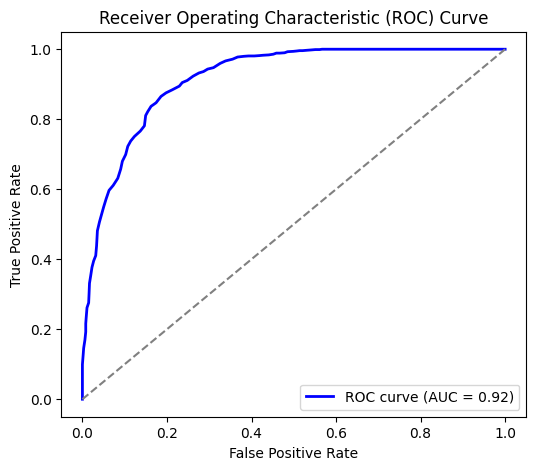

In [6]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n")
print(conf_matrix)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
y_prob = rf_classifier.predict_proba(X_test_features)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**VGG+XG** **BOOST**

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import xgboost as xgb
import seaborn as sns

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/skin_lesion/undersampled_balanced_ham10000.csv')

# Assuming the last column is the label for binary classification
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Labels

# Rescale and reshape the features (for VGG19 input)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, 64, 64, 3)  # Reshaping to match VGG19 input

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Load pre-trained VGG19 model (exclude top layers)
input_shape = (64, 64, 3)
base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_vgg19.layers:
    layer.trainable = False

# Extract features using VGG19
vgg19_model = Model(inputs=base_vgg19.input, outputs=GlobalAveragePooling2D()(base_vgg19.output))
X_train_features = vgg19_model.predict(X_train)
X_test_features = vgg19_model.predict(X_test)

# Train an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = xgb_classifier.predict(X_test_features)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

251/251 ━━━━━━━━━━━━━━━━━━━━ 518s 2s/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step
Test Accuracy: 83.47%

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1016
           1       0.80      0.88      0.84       987

    accuracy                           0.83      2003
   macro avg       0.84      0.84      0.83      2003
weighted avg       0.84      0.83      0.83      2003




Confusion Matrix:

[[799 217]
 [114 873]]


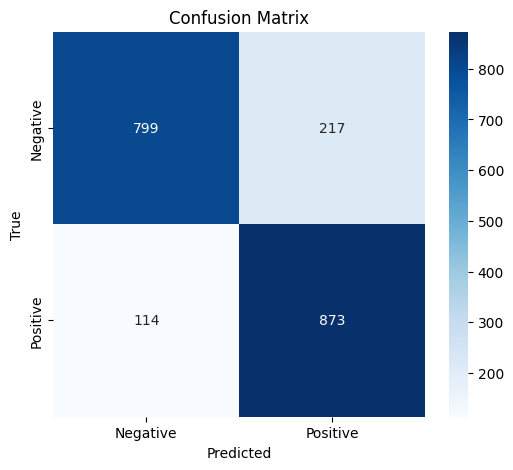

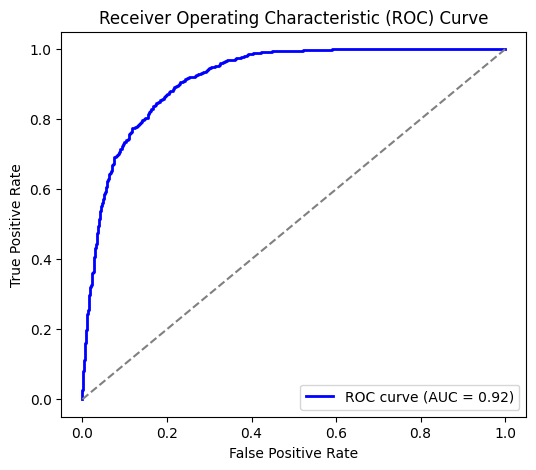

In [8]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n")
print(conf_matrix)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
y_prob = xgb_classifier.predict_proba(X_test_features)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()